# Part C

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/fin_econometrics_2/project1`


In [2]:
Pkg.instantiate()

In [3]:
include("project_functions.jl")

trainW4 (generic function with 1 method)

In [4]:
using Statistics, DataFrames, StatsPlots, TimeSeries, KernelDensity, RollingFunctions, DataFramesMeta, MarketData, Dates

## Data Preperation

In [5]:
using CSV

file_path = "/Users/sander/Documents/fin_econometrics_2/project1/aiz.csv"
aiz = CSV.File(file_path) |> DataFrame
first(aiz, 5)


5×6 DataFrame
 Row │ ret          RV         RV_p        RV_n        RS         RK      
     │ Float64      Float64    Float64     Float64     Float64    Float64 
─────┼────────────────────────────────────────────────────────────────────
   1 │  0.0120472   0.0155114  0.0125216   0.00915502   0.57316   5.09966
   2 │  0.0282087   0.0129384  0.00848344  0.00976895  -0.543282  4.25041
   3 │ -0.00291665  0.0122711  0.00972261  0.00748671   0.646612  4.3631
   4 │  0.014812    0.014421   0.011768    0.00833546   1.49139   9.69829
   5 │  0.00668774  0.0148423  0.0105351   0.0104548    0.140297  4.17256

#### HAR

Let us first consider the HAR model:
$$ RV_t = \beta_0 + \beta_1  RV_{d,t} + \beta_2  RV_{w,t} + \beta_3  RV_{m,t} + \epsilon_t $$


Hence, we will first calculate daily, weekly and monthly Realized Volatilities:

In [6]:
HAR_regressors(aiz.RV)

1478×3 Matrix{Float64}:
 0.0284341  0.0192536  0.0164559
 0.0233918  0.0204309  0.0168141
 0.0151452  0.020227   0.0169144
 0.0213311  0.0215239  0.0173262
 0.0127283  0.0202061  0.0172492
 0.0124503  0.0170093  0.0171405
 0.0149912  0.0153292  0.0169215
 0.0137577  0.0150517  0.0168273
 0.0109854  0.0129826  0.0167815
 0.0108441  0.0126057  0.0166526
 ⋮                     
 0.0171724  0.0160915  0.0137838
 0.0139953  0.0150507  0.0139307
 0.0135318  0.0149018  0.0137996
 0.0153137  0.0149716  0.0137946
 0.0188697  0.0157766  0.0140838
 0.0149667  0.0153354  0.0141763
 0.0148998  0.0155163  0.0141869
 0.0181397  0.0164379  0.0140802
 0.0147966  0.0163345  0.0140325

We can now identify the predictors and target for our study.

In [7]:
predictors = HAR_regressors(aiz.RV)
target = aiz.RV[23:end]
size(predictors), size(target)

((1478, 3), (1478,))

In [8]:
using Flux

In [9]:
xtrain = predictors[1:1000,:] |> permutedims .|> Float32
ytrain = target[1:1000] |> permutedims .|> Float32
xvalid = predictors[1001:1478,:] |> permutedims .|> Float32
yvalid = target[1001:1478] |> permutedims .|> Float32;

Note for self, the above transposes the matrices and converts the elements to 32-bit floating-point numbers.  

We now further standardize the data using ZScoreTransform.

In [10]:
using StatsBase

standardization of data:

In [11]:
fit_xt = StatsBase.fit(ZScoreTransform, log.(xtrain); dims=2, center=true, scale=true)
fit_xv = StatsBase.fit(ZScoreTransform, log.(xvalid); dims=2, center=true, scale=true)
fit_yt = StatsBase.fit(ZScoreTransform, log.(ytrain); dims=2, center=true, scale=true)
fit_yv = StatsBase.fit(ZScoreTransform, log.(yvalid); dims=2, center=true, scale=true)

ZScoreTransform{Float32, Vector{Float32}}(1, 2, Float32[-4.644698], Float32[0.33060977])

ZScoreTransform is a standardization method used to transform data into a standard normal distribution with a mean of 0 and a standard deviation of 1.

In [12]:
xt_std = StatsBase.transform(fit_xt, log.(xtrain))
xv_std = StatsBase.transform(fit_xv, log.(xvalid))
yt_std = StatsBase.transform(fit_yt, log.(ytrain))
yv_std = StatsBase.transform(fit_yv, log.(yvalid))

1×478 Matrix{Float32}:
 -0.943947  0.145748  0.869967  …  1.3257  1.92083  1.30468  0.671599

## FFNN

Now we implement the ffnn model specified in our project_functions.jl file. Note that this is the trainW3() function from the seminar with a few tweeks and changes:
- Usage of batch normalization, 
- Addition of verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0 similar to the trained model from seminar 4,
- an additional layer represented by the nodes
- different values for minimizing MSE

In [13]:
FFNN, losses11, losses12 = ffnn(xt_std, yt_std, xv_std, yv_std; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch 30 	 Loss: 1.0229547 	 Test: 1.1298184
Stopping early. No improvement in validation loss for 20 epochs.


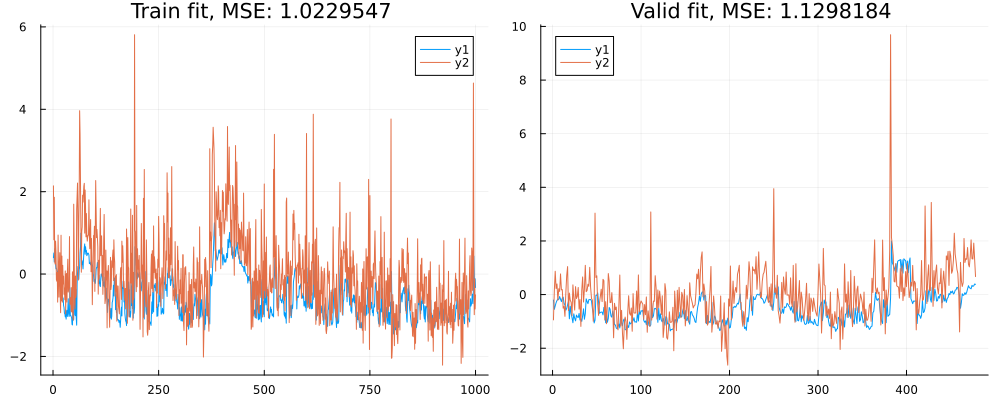

In [14]:
p1 = plot(FFNN(xt_std)', title="Train fit, MSE: $(Flux.Losses.mse(FFNN(xt_std),yt_std)) ",)
p1 = plot!(yt_std')
#
p2 = plot(FFNN(xv_std)', title="Valid fit, MSE: $(Flux.Losses.mse(FFNN(xv_std),yv_std)) ",)
p2 = plot!(yv_std');
plot(p1, p2, size=(1000, 400))

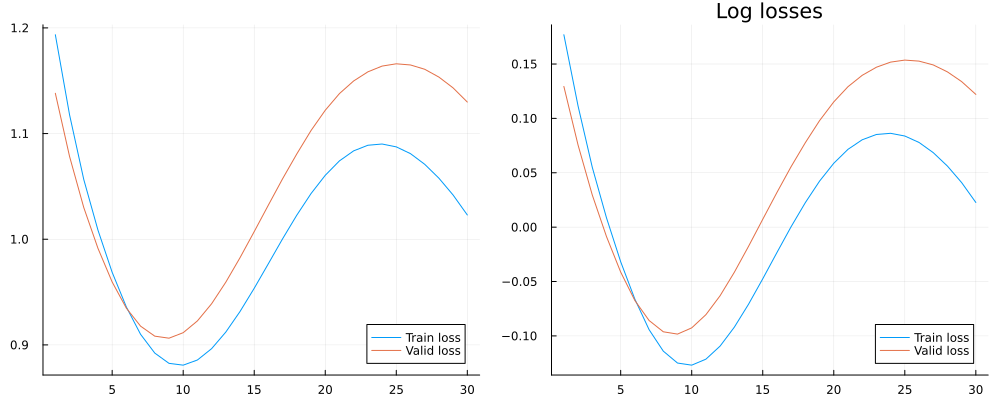

In [15]:
p11 = plot([losses11 losses12], labels=["Train loss" "Valid loss"])
p12 = plot(log.([losses11 losses12]), labels=["Train loss" "Valid loss"], title="Log losses") # might help at some cases
plot(p11, p12, size=(1000,400))

In [16]:
using Distributions

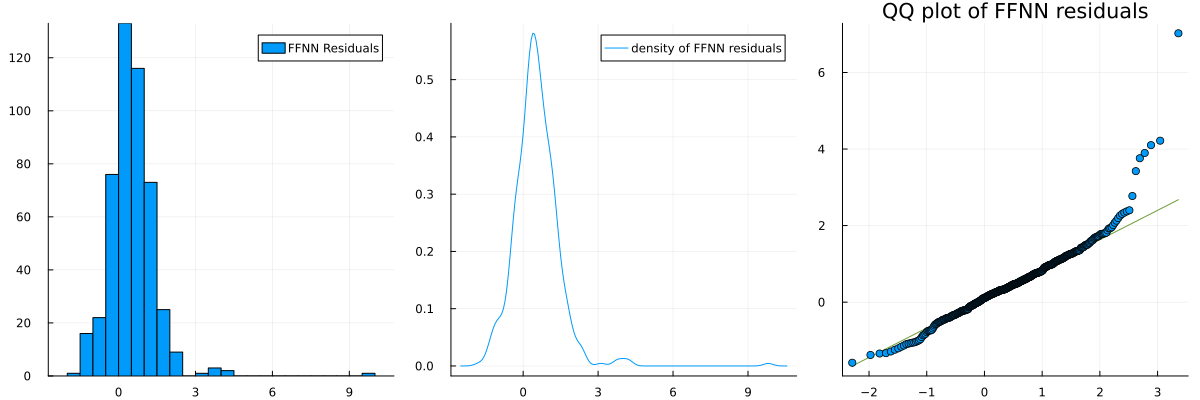

In [17]:
FFNN_resid = yv_std - FFNN(xv_std)
FFNN_quantiles = quantile(Normal(), LinRange(0, 1, length(FFNN_resid)))

qq1 = histogram(FFNN_resid', label = "FFNN Residuals")
qq2 = density(FFNN_resid', label="density of FFNN residuals")
qq3 = qqnorm(vec(FFNN_resid), qqline = :R, title = "QQ plot of FFNN residuals")
plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

## RNN

In [18]:
xt_rnn = reshape(xt_std, 3, 1, :)
yt_rnn = reshape(yt_std, 1, 1, :)
xv_rnn = reshape(xv_std, 3, 1, :)
yv_rnn = reshape(yv_std, 1, 1, :);

Each "slice" along the third axis represents a sequence of length 3 for x and 1 for y, and the second dimension is used for processing elements within the sequence independently. This reshaping is often used in RNNs where the input is organized as sequences of data, and the network processes each sequence element iteratively. 

In [19]:
size(xt_std), size(yt_std)

((3, 1000), (1, 1000))

In [20]:
size(xt_rnn), size(yt_rnn)

((3, 1, 1000), (1, 1, 1000))

We now see the transformed 3D shape. 

In [21]:
mo1, mb1, lt1, lv1 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch [1/500] 	 Training Loss 0.8 	 Validation Loss 0.86


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 3


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 11


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 12


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 13


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 19


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 20


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 21


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 22


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.78


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 35


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 36


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 37


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.76


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 64


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 65


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 66


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 67


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 68


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 69
 □ Epoch 69 	 Patience is LOST :) 


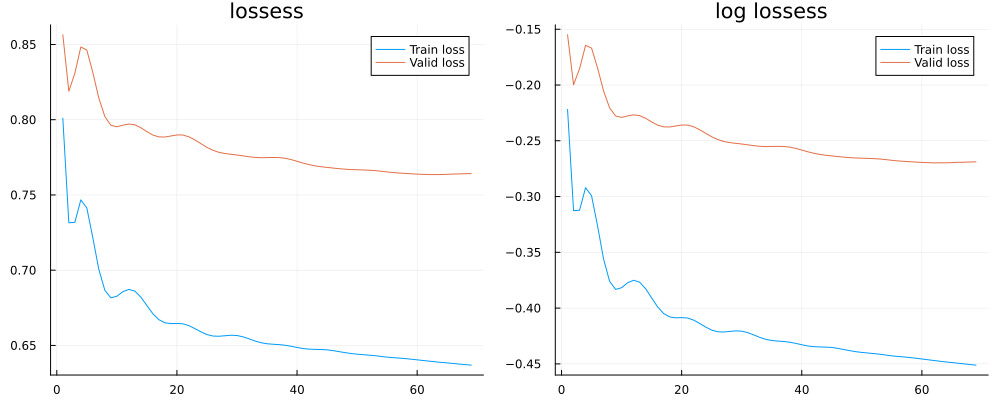

In [22]:
p3l = plot([lt1 lv1], labels=["Train loss" "Valid loss"], title = "lossess")
p4l = plot(log.([lt1 lv1]), labels=["Train loss" "Valid loss"], title = "log lossess")
plot(p3l, p4l, size=(1000,400))

In [23]:
Flux.reset!(mo1) # reset hidden
mo1(xt_rnn) # warm-up model
yhat_mo1_valid = mo1(xv_rnn) |> vec;

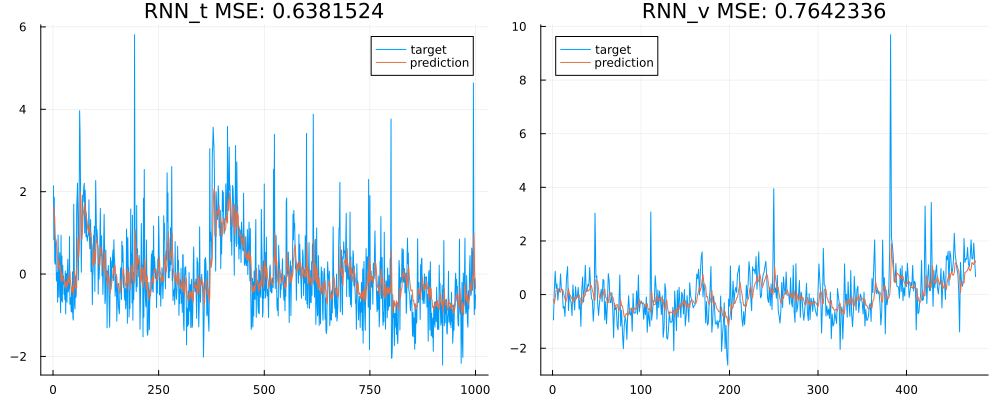

In [24]:
t_fit = mo1(xt_rnn)
plt_tld = plot(yt_rnn |> vec; label="target")
plt_tld = plot!(t_fit |> vec; label="prediction", title="RNN_t MSE: $(Flux.mse(t_fit, yt_rnn))", size = (1000,400))
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="prediction", title="RNN_v MSE: $(Flux.mse(pred_fit, yv_rnn))", size = (1000,400))
plot(plt_tld,plt_vld, size = (1000,400))

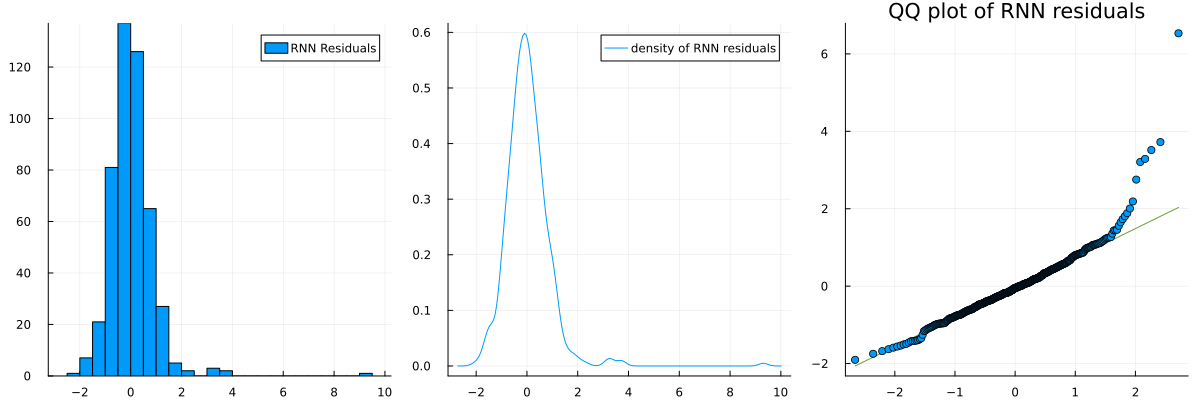

In [25]:
RNN_resid = yv_rnn .- reshape(yhat_mo1_valid, size(yv_rnn))
RNN_resid = dropdims(RNN_resid, dims=(1, 2))

qq1 = histogram(RNN_resid, label = "RNN Residuals")
qq2 = density(RNN_resid, label="density of RNN residuals")
qq3 = qqnorm(RNN_resid, qqline = :R, title = "QQ plot of RNN residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## OLS

In [26]:
beta_har = OLSestimatorconst(yt_std', xt_std')

4×1 Matrix{Float64}:
 -3.882047456706694e-6
  0.2248106998945492
  0.20034621642730782
  0.2262657316061861

In [30]:
yhat_beta = [ones(size(xv_std',1)) xv_std'] * beta_har;
y_beta = [ones(size(xt_std',1)) xt_std'] * beta_har;

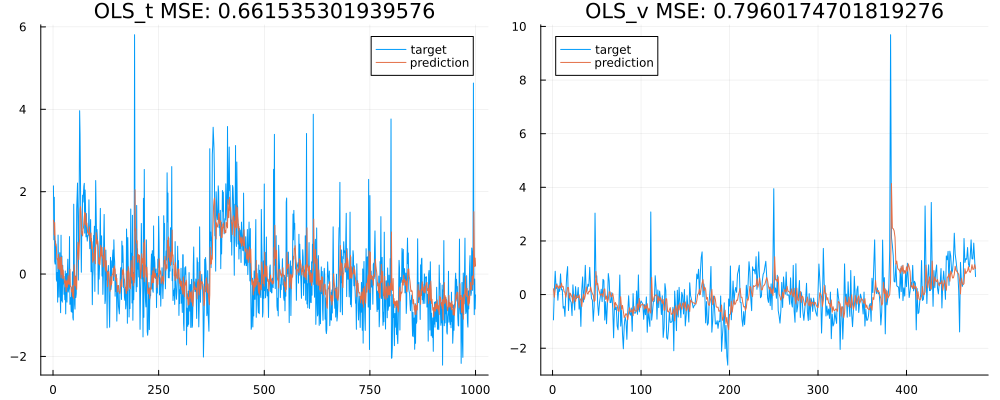

In [31]:
plt_ols_t = plot(yt_std'; label="target")
plt_ols_t = plot!(y_beta; label="prediction", title="OLS_t MSE: $(Flux.mse(y_beta, yt_std'))", size = (1000,400))
plt_ols_v = plot(yv_std'; label="target")
plt_ols_v = plot!(yhat_beta; label="prediction", title="OLS_v MSE: $(Flux.mse(yhat_beta, yv_std'))", size = (1000,400))
plot(plt_ols_t,plt_ols_v, size = (1000,400))

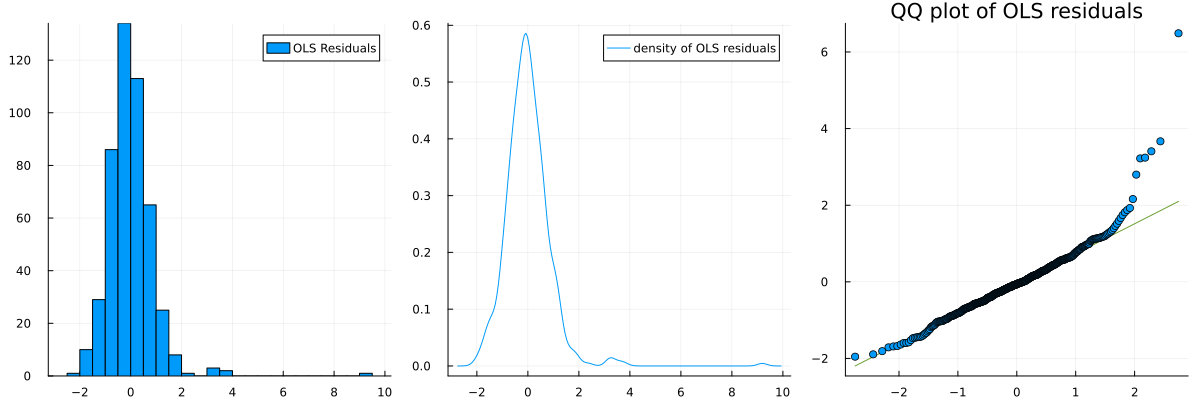

In [32]:
OLS_resid = yv_std' .- yhat_beta

qq1 = histogram(OLS_resid, label = "OLS Residuals")
qq2 = density(OLS_resid, label="density of OLS residuals")
qq3 = qqnorm(vec(OLS_resid), qqline = :R, title = "QQ plot of OLS residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## Comparison

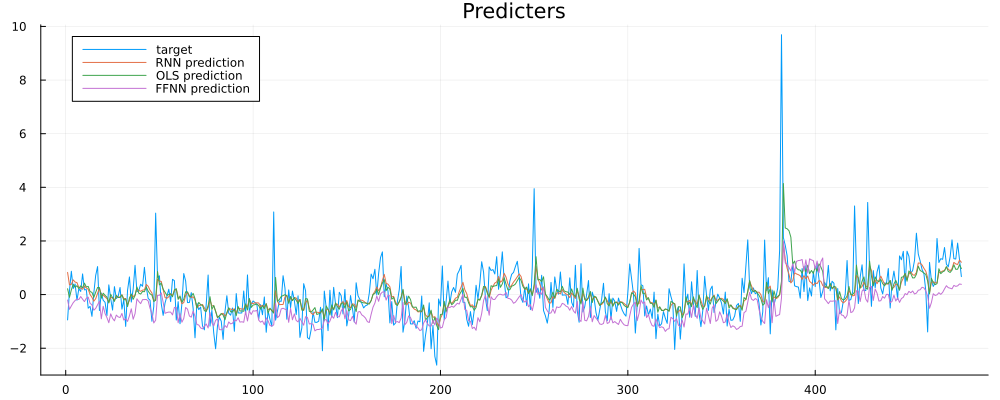

In [33]:
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="RNN prediction", title="Predicters")
plt_vld = plot!(yhat_beta; label="OLS prediction", size = (1000,400))
plt_vld = plot!(FFNN(xv_std)'; label = "FFNN prediction")

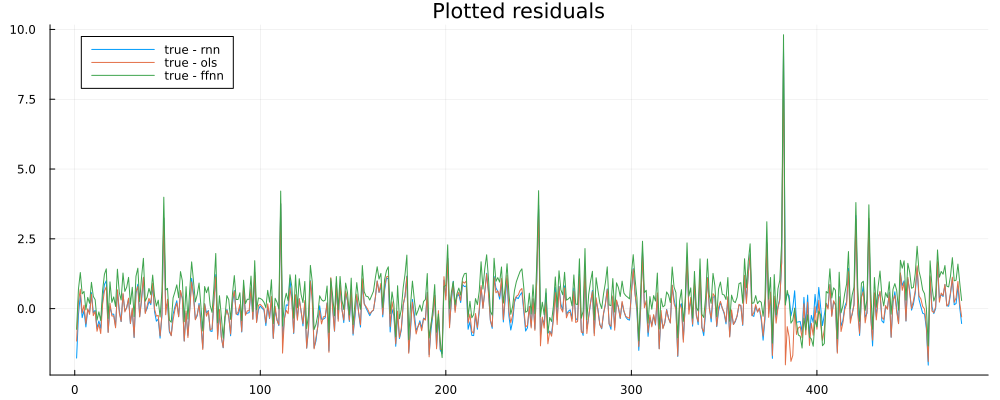

In [34]:
plot(yv_rnn[:] .- pred_fit[:], label="true - rnn")
plot!(yv_rnn[:]  .- yhat_beta, label="true - ols")
plot!(yv_rnn[:] .- FFNN(xv_std)[:], label="true - ffnn", size = (1000, 400), title = "Plotted residuals")


In [35]:
FFNN_MSE_t = Flux.Losses.mse(FFNN(xt_std),yt_std)
FFNN_MSE_v = Flux.Losses.mse(FFNN(xv_std),yv_std)
RNN_MSE_t = Flux.mse(mo1(xt_rnn), yt_rnn)
RNN_MSE_v = Flux.mse(mo1(xv_rnn), yv_rnn)
OLS_MSE_t = Flux.mse(y_beta, yt_std')
OLS_MSE_v = Flux.mse(yhat_beta, yv_std')

0.7960174701819276

In [36]:
analysis = DataFrame(
    Model = ["OLS", "FFNN", "RNN"],
    MSE_t = [OLS_MSE_t, FFNN_MSE_t, RNN_MSE_t],
    MSE_v = [OLS_MSE_v, FFNN_MSE_v, RNN_MSE_v]
)

# Display the DataFrame
display(analysis)

3×3 DataFrame
 Row │ Model   MSE_t     MSE_v    
     │ String  Float64   Float64  
─────┼────────────────────────────
   1 │ OLS     0.661535  0.796017
   2 │ FFNN    1.02295   1.12982
   3 │ RNN     0.638152  0.764234

---

## Ensemble

FFNN

In [38]:
FFNN_n_ensembles = 5
FFNN_arr_models = []
FFNN_ens_loss_t = []
FFNN_ens_loss_v = []
for iens in 1:FFNN_n_ensembles
    println("> Running ensemble $iens")
    @time FFNN0, losses01, losses02 = ffnn(xt_std, yt_std, xv_std, yv_std; nodes=[100, 50, 30], eta=0.001,
    n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);
    # _ saving
    push!(FFNN_arr_models, FFNN0) # saving the best model for each ensemble
    push!(FFNN_ens_loss_t, losses01)
    push!(FFNN_ens_loss_v, losses02)
end

> Running ensemble 1


Epoch 30 	 Loss: 0.7632984 	 Test: 0.845627
Stopping early. No improvement in validation loss for 20 epochs.


  0.759483 seconds (154.21 k allocations: 601.001 MiB, 8.15% gc time, 4.20% compilation time)
> Running ensemble 2
Stopping early. No improvement in validation loss for 20 epochs.


  0.384128 seconds (36.38 k allocations: 292.599 MiB, 6.61% gc time)
> Running ensemble 3
Epoch 30 	 Loss: 

0.69052553 	 Test: 0.8137567


Stopping early. No improvement in validation loss for 20 epochs.
  0.996793 seconds (73.91 k allocations: 595.523 MiB, 4.81% gc time)
> Running ensemble 4


Epoch 30 	 Loss: 0.68113893 	 Test: 0.824914
Epoch 60 	 Loss: 

0.60506076 	 Test: 0.8081648


Stopping early. No improvement in validation loss for 20 epochs.
  0.698778 seconds (99.83 k allocations: 804.437 MiB, 8.11% gc time)
> Running ensemble 5


Epoch 30 	 Loss: 0.67646927 	 Test: 0.7995964
Epoch 60 	 Loss: 

0.5984022 	 Test: 0.7959606


Stopping early. No improvement in validation loss for 20 epochs.
  0.774362 seconds (92.09 k allocations: 741.764 MiB, 6.69% gc time)


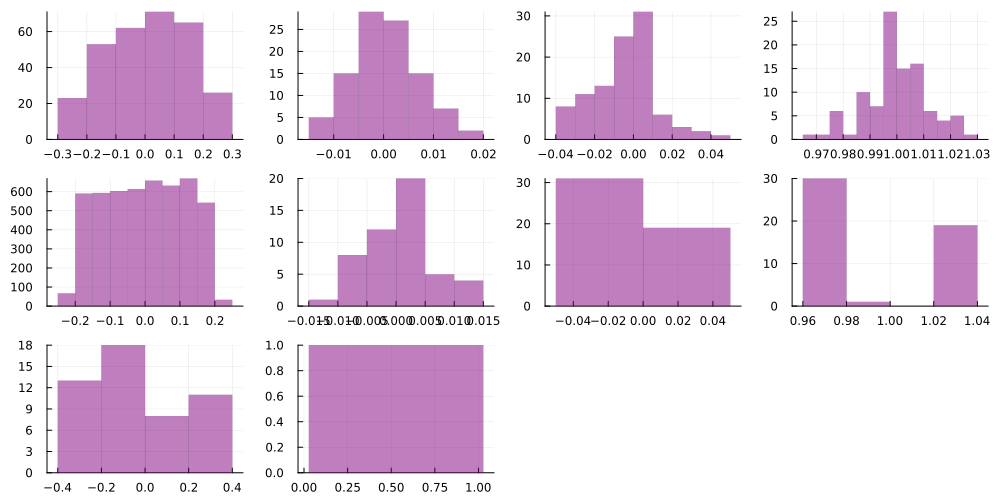

In [43]:
m_pars = Flux.params(FFNN_arr_models[1]) |> collect .|> vec
plot(histogram.(m_pars)..., line=(0), fill=(1, 0.5, :purple), legend=:none, size = (1000, 500))

In [46]:
yhat_array_FFNN = []
for m in FFNN_arr_models
    Flux.reset!(m) # reset model
    m(xt_std) # warm-up the model for time step prior prediction
    push!(yhat_array_FFNN, m(xv_std))
end
yhat_ensemble_FFNN = mean(yhat_array_FFNN) |> vec;

In [47]:
RNN_n_ensembles = 5
RNN_arr_models = []
RNN_ens_loss_t = []
RNN_ens_loss_v = []
for iens in 1:n_ensembles
    println("> Running ensemble $iens")
    @time mo0, mb0, lt0, lv0 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
    n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0)
    # _ saving
    push!(RNN_arr_models, mb0) # saving the best model for each ensemble
    push!(RNN_ens_loss_t, lt0)
    push!(RNN_ens_loss_v, lv0)
end

> Running ensemble 1


Epoch [1/500] 	 Training Loss 0.88 	 Validation Loss 0.92


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 6


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.78


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 40


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 41


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 42


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 72


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 73


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 74


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 75


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 76


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 77


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 78


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 79


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 80


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 81


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 82


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 83


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 84


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 85
 □ Epoch 85 	 Patience is LOST :) 
 11.009683 seconds (11.76 M allocations: 30.337 GiB, 25.74% gc time)
> Running ensemble 2


Epoch [1/500] 	 Training Loss 0.75 	 Validation Loss 0.84


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 3


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 9


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 10


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 11


Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 54


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 57


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 58
  ⊚ Counted +1 in patience, 10/20 	 Epoch: 59


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 60


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 61
Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 62


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 63


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 64
  ⊚ Counted +1 in patience, 16/20 	 Epoch: 65


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 66
  ⊚ Counted +1 in patience, 18/20 	 Epoch: 67


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 68


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 69
 □ Epoch 69 	 Patience is LOST :) 
  7.530070 seconds (9.55 M allocations: 24.626 GiB, 26.10% gc time)
> Running ensemble 3


Epoch [1/500] 	 Training Loss 0.73 	 Validation Loss 0.83


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 2


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 3
  ⊚ Counted +1 in patience, 3/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 16


Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.78


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 60


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 61
Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 62


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 63


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 64
  ⊚ Counted +1 in patience, 10/20 	 Epoch: 65


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 66


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 67


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 68


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 69


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 70


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 71


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 72


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 73
  ⊚ Counted +1 in patience, 19/20 	 Epoch: 74


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 75
 □ Epoch 75 	 Patience is LOST :) 
  8.214477 seconds (10.38 M allocations: 26.768 GiB, 25.85% gc time)
> Running ensemble 4
Epoch [1/500] 	 Training Loss 0.75 	 Validation Loss 0.84


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 3


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 9


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 10


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 31
Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.78


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 63


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 64


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 65


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 66


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 67


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 68
  ⊚ Counted +1 in patience, 12/20 	 Epoch: 69


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 70


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 71


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 72


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 73


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 74
  ⊚ Counted +1 in patience, 18/20 	 Epoch: 75


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 76


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 77
 □ Epoch 77 	 Patience is LOST :) 
  8.133831 seconds (10.65 M allocations: 27.481 GiB, 26.63% gc time)
> Running ensemble 5


Epoch [1/500] 	 Training Loss 0.91 	 Validation Loss 0.94


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 4
  ⊚ Counted +1 in patience, 2/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 7


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 8


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 9


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 13
  ⊚ Counted +1 in patience, 8/20 	 Epoch: 14


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 15


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 16


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 23


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 24


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 25
  ⊚ Counted +1 in patience, 14/20 	 Epoch: 26


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 27


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 28


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 29


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.78


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 80


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 81


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 82
 □ Epoch 82 	 Patience is LOST :) 
  8.652807 seconds (11.34 M allocations: 29.266 GiB, 27.28% gc time)


Plotting coefficients of the first model

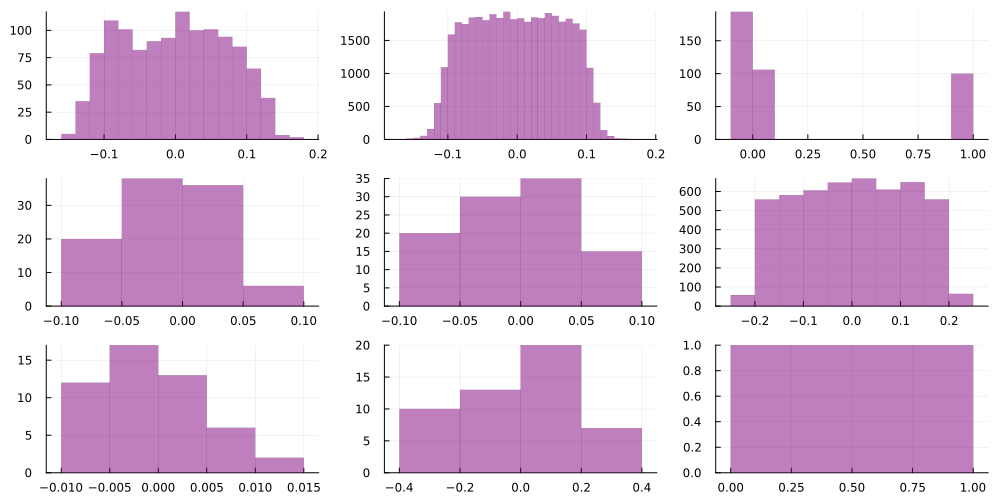

In [48]:
m_pars = Flux.params(RNN_arr_models[1]) |> collect .|> vec
plot(histogram.(m_pars)..., line=(0), fill=(1, 0.5, :purple), legend=:none, size = (1000, 500))

Plot losses of all models in ensemble
Fit all models to see the output (still on validation which we use in training for stopping, for instance, thus not true Out-of-sample):

In [49]:
yhat_array_RNN = []
for m in RNN_arr_models
    Flux.reset!(m) # reset model
    m(xt_rnn) # warm-up the model for time step prior prediction
    push!(yhat_array_RNN, m(xv_rnn))
end
yhat_ensemble_RNN = mean(yhat_array_RNN) |> vec;

HAR prediction

In [50]:
har_coefs = OLSestimatorconst(yt_std', xt_std')
yhat_har_valid = (xv_std' * har_coefs[2:end]) .+ har_coefs[1];

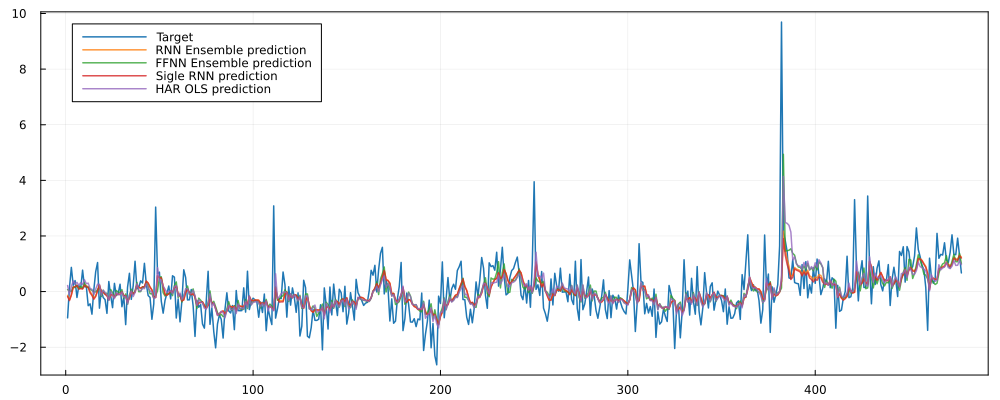

In [52]:
plot(yv_rnn |> vec, label="Target", size=(1000,400), framestyle=:box, line=(1.5, 1.0, :solid), palette=:tab10)
plot!(yhat_ensemble_RNN, label="RNN Ensemble prediction", line=(1.5, 0.8, :solid))
plot!(yhat_ensemble_FFNN, label="FFNN Ensemble prediction", line=(1.5, 0.8, :solid))
plot!(yhat_mo1_valid, label="Sigle RNN prediction", line=(1.5, 0.8, :solid))
plot!(yhat_har_valid, label="HAR OLS prediction", line=(1.5, 0.8, :solid))


In [63]:
analysis = DataFrame(
    Model = ["OLS", "FFNN", "FFNN_ENS", "RNN", "RNN_ENS"],
    MSE_v = [OLS_MSE_v, FFNN_MSE_v, Flux.mse(yhat_ensemble_FFNN, yv_rnn |> vec), RNN_MSE_v, Flux.mse(yhat_ensemble_RNN, yv_rnn |> vec)]
)

display(analysis)

5×2 DataFrame
 Row │ Model     MSE_v    
     │ String    Float64  
─────┼────────────────────
   1 │ OLS       0.796017
   2 │ FFNN      1.12982
   3 │ FFNN_ENS  0.802161
   4 │ RNN       0.764234
   5 │ RNN_ENS   0.764585

Let's see the individual predictions:

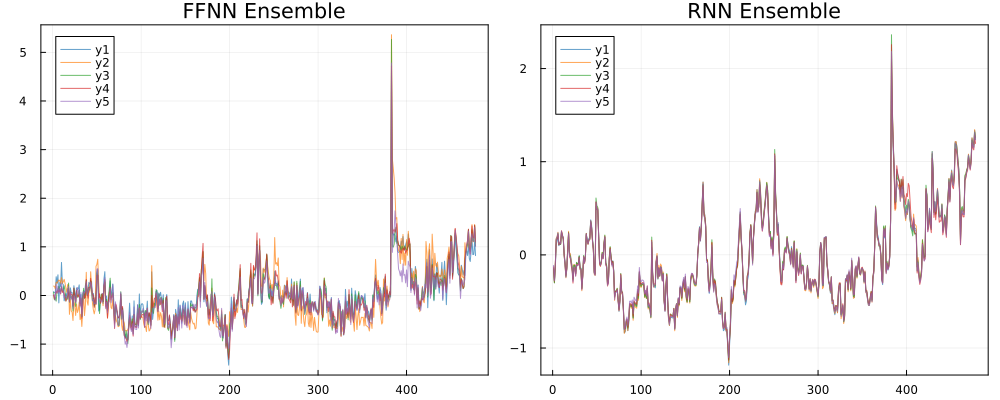

In [54]:
ens1 = plot(yhat_array_FFNN .|> vec, framestyle=:box, line=(1, 0.7, :solid), palette=:tab10, title = "FFNN Ensemble")
ens2 = plot(yhat_array_RNN .|> vec, framestyle=:box, line=(1, 0.7, :solid), palette=:tab10, title = "RNN Ensemble")
plot(ens1, ens2, size = (1000,400))

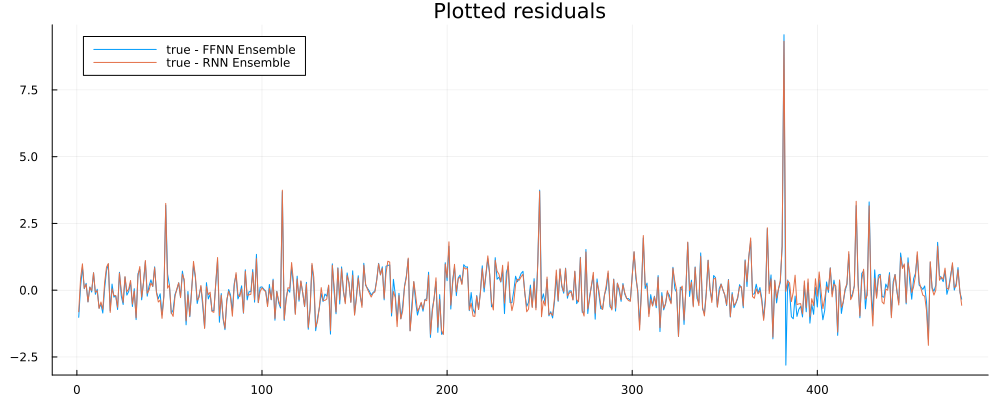

In [55]:
plot(yv_rnn[:]  .- yhat_ensemble_FFNN[:], label="true - FFNN Ensemble")
plot!(yv_rnn[:] .- yhat_ensemble_RNN[:], label="true - RNN Ensemble", size = (1000, 400), title = "Plotted residuals")

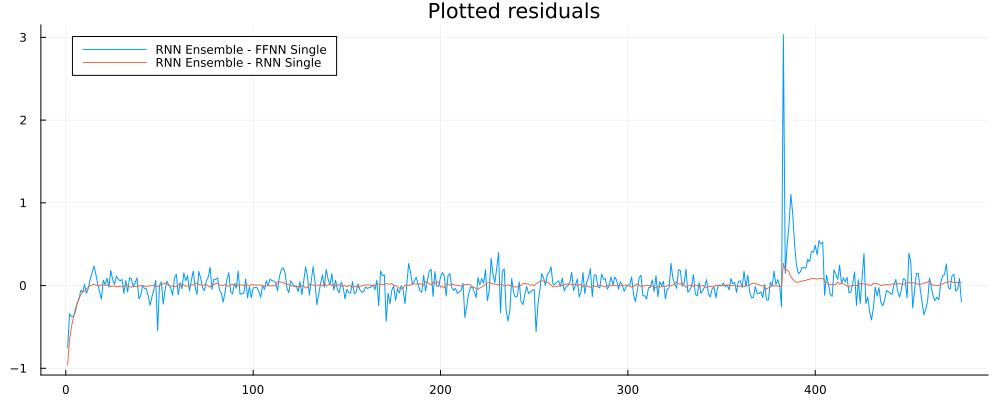

In [57]:
plot(yhat_ensemble_FFNN[:] .- pred_fit[:], label="RNN Ensemble - FFNN Single")
plot!(yhat_ensemble_RNN[:] .- pred_fit[:], label="RNN Ensemble - RNN Single", size = (1000, 400), title = "Plotted residuals")